# Workers ring fire monitoring

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthenticator
from cassandra.query import dict_factory
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

In [3]:
seeds = ['127.0.0.1', '10.7.0.10', '10.7.0.21']

In [4]:
cluster = Cluster(contact_points=seeds, port=9042) #, auth_provider=auth_provider)

In [85]:
session = cluster.connect(keyspace='temp')
session.row_factory = pandas_factory
session.default_fetch_size = 55

In [86]:
# fetch data from cassandra db
cql = "select toTimeStamp(id) as date, ip, last_run, message, workers_count from temp.log;"
res = session.execute(cql, timeout=5)
df = res._current_rows
df = df.set_index('date')
df['timestamp'] = np.int64(df.index.to_series().apply(pd.Timestamp).astype(np.int64).values / 1e6)

df1 = df[df.ip=='79.111.12.34']
df2 = df[df.ip=='195.68.129.2']
df3 = df[df.ip=='188.32.153.99']

start_ts = int(df.index.min().timestamp()*1000)
end_ts = int(df.index.max().timestamp()*1000)

df.head(10)

,ip,last_run,message,workers_count,timestamp
date,,,,,
2018-07-06 17:29:41.662,188.32.153.99,2018-07-06 17:29:41.684,GORO,None,1530898181662
2018-07-06 17:29:38.608,188.32.153.99,2018-07-06 17:29:38.493,GORO,None,1530898178608
2018-07-06 17:29:35.312,188.32.153.99,2018-07-06 17:29:35.333,GORO,None,1530898175312
2018-07-06 17:29:33.778,188.32.153.99,2018-07-06 17:29:33.692,GORO,None,1530898173777
2018-07-06 17:29:30.568,188.32.153.99,2018-07-06 17:29:30.594,GORO,None,1530898170568
2018-07-06 17:29:29.034,195.68.129.2,2018-07-06 17:29:28.992,Ganymede,None,1530898169033
2018-07-06 17:29:27.515,188.32.153.99,2018-07-06 17:29:27.428,GORO,None,1530898167515
2018-07-06 17:29:26.028,195.68.129.2,2018-07-06 17:29:25.909,Ganymede,None,1530898166028
2018-07-06 17:29:24.333,188.32.153.99,2018-07-06 17:29:24.317,GORO,None,1530898164333


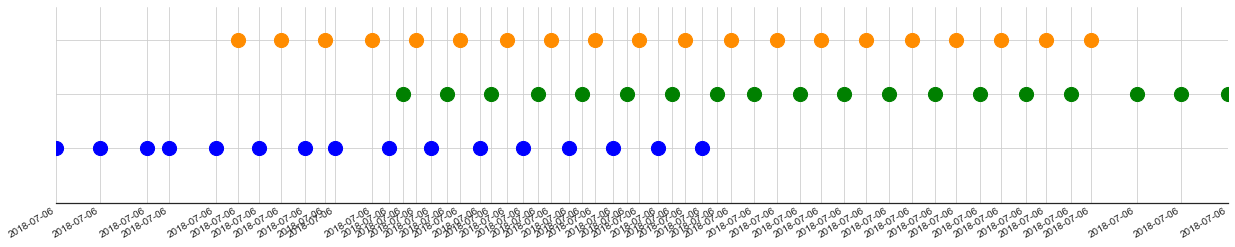

In [87]:
x1 = pd.to_datetime(df1.index)
y1 = df1.workers_count.values
x2 = pd.to_datetime(df2.index)
y2 = df2.workers_count.values
x3 = pd.to_datetime(df3.index)
y3 = df3.workers_count.values

fig, ax = plt.subplots(figsize=(21,4))
ax.scatter(x1, [1]*len(x1), marker='o', s=200, color='green')
ax.scatter(x2, [1.5]*len(x2), marker='o', s=200, color='darkorange')
ax.scatter(x3, [0.5]*len(x3), marker='o', s=200, color='blue')

fig.autofmt_xdate()
plt.grid(True)
plt.ylim(0, 1.8)

#ax.yaxis.set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')

ax.get_yaxis().set_ticklabels([])
space = pd.to_timedelta(2, unit='s') # 1 second interval to prepend
plt.xlim(x1[0] - space, x2[-1] + space)
ax.set_xticks(x1.append(x2).append(x3), minor=False)
ax.set_yticks([0.5,1,1.5], minor=False)

plt.show()